# Differential Expression and Pathway analysis
The goal of this notebook is to take the processed feature counts and experimental design tables and use GSEA, ROntoTools, and QuaternaryProd to generate and compare pathway analyses. This notebook runs code in R using the DESeq2 differential expression package.

1. input full featureCount tables into DESeq2
2. ROntoTools
3. GSEA
4. QuaternaryProd with STRING database

## Preparation
1. install R packages (see R install document)


## Instructions
Before running this notebook, format the feature count data with the featureCountprocessing-generic notebook. The notebooks are separated because the processing notebook runs Python code, not R. Once the processed featureCounts and experimental design table have been created:

1. Run the first cell to import the necessary libraries and define the functions used to process the data.
2. 

In [220]:
#import libraries
library("DESeq2")

#define functions for DESeq2 object creation and heatmap creation
#based on Griffith Lab tutorial here: https://genviz.org/module-04-expression/0004/02/01/DifferentialExpression/

#input and process sample data (experiment design)
input_sample_data <- function(filepath, print_debug=FALSE){
    sampleData <- read.delim(filepath)
    #save copy of sampleData
    #sampleData_v2 <- sampleData
    
    rownames(sampleData) <- sampleData$SampleID.Lab
    #make data type = factor for Cell Line and Time Point (both otherwise treated as continuous variables since both are numbers)
    sampleData$Cell.Line <- factor(sampleData$Cell.Line)
    sampleData$Time.Point <- factor(sampleData$Time.Point)
    if(print_debug == TRUE){
        print(head(sampleData))
        }
    return(sampleData)
}

#Input and process raw gene counts (Feature Counts)
input_raw_counts <- function(filepath, sampleData, print_debug=FALSE){
    rawCounts <- read.delim(filepath)
    #print(head(rawCounts))
    
    geneID <- rawCounts$Geneid
    sampleIndex <- grepl("ES\\d+", colnames(rawCounts))
    rawCounts <- as.matrix(rawCounts[,sampleIndex])
    rownames(rawCounts) <- geneID
     if(print_debug == TRUE){
        print(head(rawCounts))
    }
    rawCounts <- rawCounts[,unique(rownames(sampleData))]
    if(print_debug == TRUE){
        print(head(rawCounts))
    }
    cat("Test that dimensions of rawCounts and sampleData match:", all(colnames(rawCounts) == rownames(sampleData)), "\n")
    return(rawCounts)
}


## Comparisons to make:
1. MRTX alone vs. MRTX + BI and vs MRTX + SHP2i at 6 and 72 hr (H358 only for SHP2i)
2. 0 vs. 6, 0 vs. 72 hr, and 6 hr vs. 72 hr within drug treatments
4. MRTX + BI vs MRTX + SHP2i at 6 and 72 hr (H358 only)
5. S2 KO vs S2 KO + MRTX
6. NT + MRTX + BI vs S2 KO + MRTX + BI

In [221]:
#H358 input rawCounts (featureCounts) and sample data (experimental design)
sampleData_H358 <- input_sample_data("20210209_experiment_design_H358.tsv")
rawCounts_H358 <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358 <- DESeqDataSetFromMatrix(countData=rawCounts_H358, colData=sampleData_H358, design= ~ CRISPR + Time.Point)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [222]:
sampleData_H358_72_MB <- input_sample_data("20210209_experiment_design_H358_72_MB.tsv")
rawCounts_H358_72_MB <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358_72_MB)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358_72_MB <- DESeqDataSetFromMatrix(countData=rawCounts_H358_72_MB, colData=sampleData_H358_72_MB, design= ~ Population + BI)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [223]:
#View sampleData to understand its format/information when choosing variables later
head(sampleData_H358)

,X,SampleID.Lab,Cell.Line,Inhibition.Status,CRISPR,MRTX,BI,SHP2i,Time.Point,Population
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ES58NTXX01,0,ES58NTXX01,58,NTXX,NT,False,False,False,0,A
ES58NTXX02,1,ES58NTXX02,58,NTXX,NT,False,False,False,0,A
ES58NTXX03,2,ES58NTXX03,58,NTXX,NT,False,False,False,0,B
ES58NTXX04,3,ES58NTXX04,58,NTXX,NT,False,False,False,0,B
ES58S1XX01,4,ES58S1XX01,58,S1XX,S1,False,False,False,0,A
ES58S1XX02,5,ES58S1XX02,58,S1XX,S1,False,False,False,0,A


In [224]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
##Make function
print(dim(dds_H358))
print(dim(dds_H358[rowSums(counts(dds_H358)) > 5, ]))
dds_H358 <- dds_H358[rowSums(counts(dds_H358)) > 5, ]

[1] 63677    59
[1] 34696    59


In [225]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
print(dim(dds_H358_72_MB))
print(dim(dds_H358_72_MB[rowSums(counts(dds_H358_72_MB)) > 5, ]))
dds_H358_72_MB <- dds_H358_72_MB[rowSums(counts(dds_H358_72_MB)) > 5, ]

[1] 63677     8
[1] 27119     8


In [226]:
#load BiocParallel library and register number of cores to use (based on CPU) for parallel processing to increase speed
#if used set parallel = TRUE for DEseq() and results()
library(BiocParallel)
register(MulticoreParam(4))

In [227]:
#perform DESeq on dataset object to estimate size factors, dispersion, and find negative bionomial GLM fitting and Wald statistic
#Takes 5-10 minutes without parallel processing, 1-5 minutes with 4 cores
dds_H358_DESeq <- DESeq(dds_H358, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [57]:
dds_H358_results <- results(dds_H358_DESeq, contrast=c("Time.Point", "0", "72"))
summary(dds_H358_results)


out of 42301 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6522, 15%
LFC < 0 (down)     : 7624, 18%
outliers [1]       : 2, 0.0047%
low counts [2]     : 15167, 36%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [230]:
#Option: Can just write to csv
#write.csv(as.data.frame(dds), file="results.csv")

#write to RData file: includes results, dds, and experiment design
#from https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2020/RNAseq/html/04_DE_analysis_with_DESeq2.html#finally-save-the-results-in-a-new-rdata-object
#label file with conditions used to make dds
save(dds_H358_results, dds_H358_DESeq, sampleData_H358, file="Results/RData/H358_CRISPR_TimePt.RData")


## Quality control plots for whole dataset

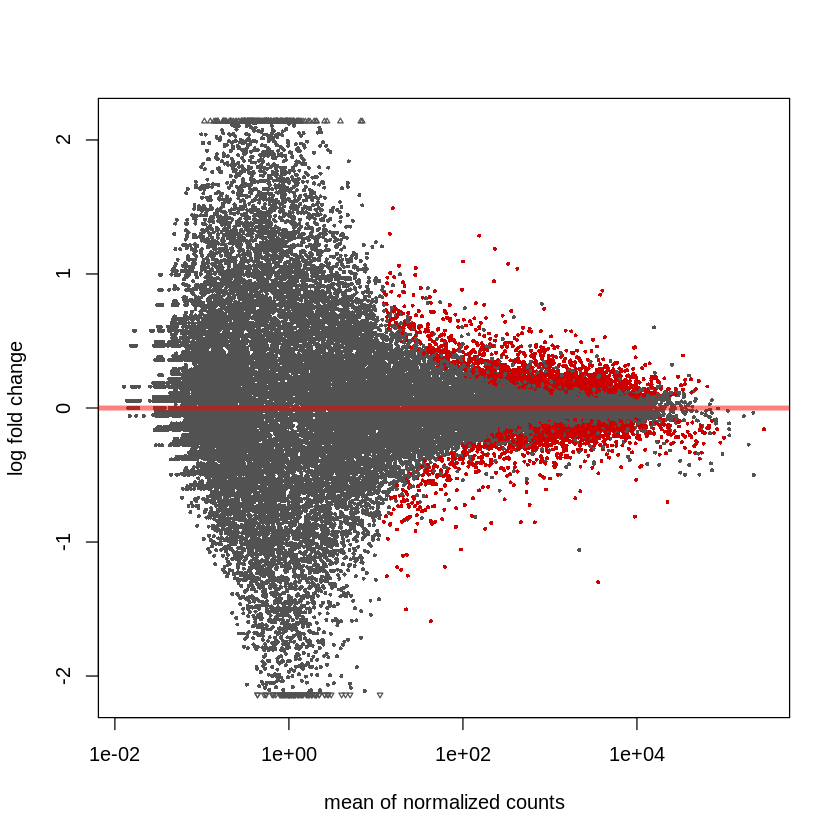

In [27]:
plotMA(dds_H358_results)


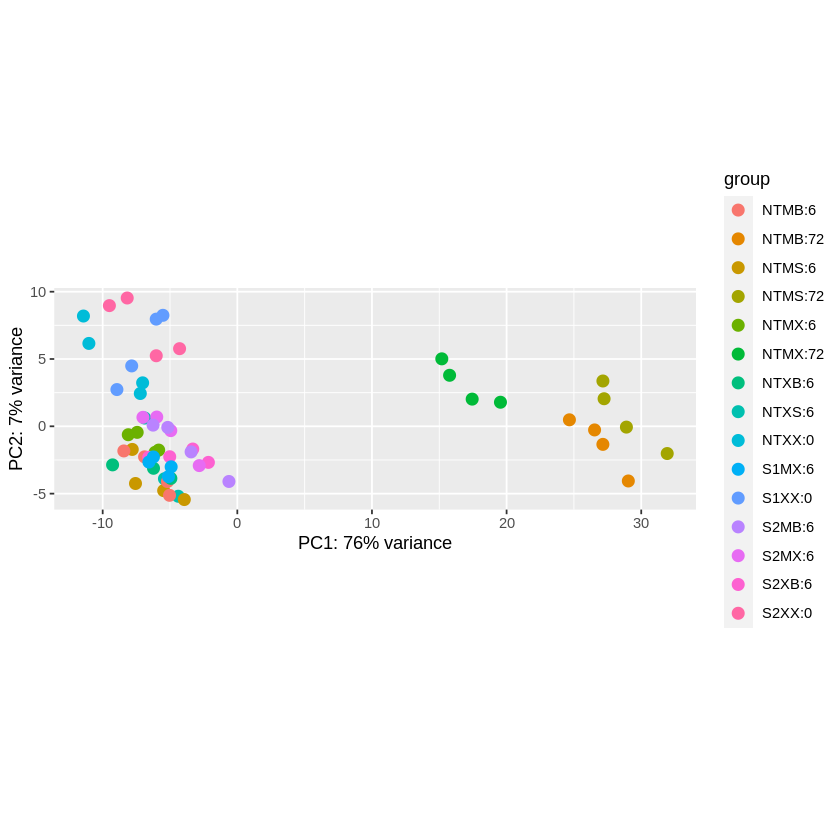

In [30]:
#PCA and sample distances
vsd <- vst(dds_H358_DESeq, blind=FALSE)
plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))

In [34]:
plt <- plotPCA(vsd, intgroup=c("CRISPR", "Population"))

In [38]:
#print to file
png("Results/H358_PCA_cell_pop.png")
print(plt)
dev.off()

png 
  2

In [39]:
plt <- plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))
png("Results/H358_PCA_inhib-timept.png")
print(plt)
dev.off()

png 
  2

In [ ]:
#save dds object as .RData
#from https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2020/RNAseq/html/04_DE_analysis_with_DESeq2.html#finally-save-the-results-in-a-new-rdata-object
#Extract the default contrast - Lacate v Virgin
#resLvV <- results(ddsObj, alpha=0.05)
#save(resLvV, ddsObj, sampleinfo, file="results/DE.RData")


## Set up dataset subsets for comparisons

In [231]:
#only 72 hour MRTX vs MRTX + BI comparison
dds_H358_72_MB <- DESeq(dds_H358_72_MB, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [67]:
dds_H358_72_MB$Inhibition.Status <- relevel(dds_H358_72_MB$Inhibition.Status, ref = "NTMX")
dds_H358_72_MB$Inhibition.Status

[1] NTMX NTMX NTMX NTMX NTMB NTMB NTMB NTMB
Levels: NTMX NTMB

In [74]:
dds_H358_72_MB_results <- results(dds_H358_72_MB, name="BI_True_vs_False")
summary(dds_H358_72_MB_results)


out of 27119 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1578, 5.8%
LFC < 0 (down)     : 1181, 4.4%
outliers [1]       : 0, 0%
low counts [2]     : 10516, 39%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [232]:
#write to RData file: includes results, dds, and experiment design
#from https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2020/RNAseq/html/04_DE_analysis_with_DESeq2.html#finally-save-the-results-in-a-new-rdata-object
#label file with conditions used to make dds
save(dds_H358_72_MB_results, dds_H358_72_MB, sampleData_H358_72_MB, file="Results/RData/H358_72_MB_Population_BI.RData")

# Implement Pathway Analysis: Format data

Both ROntoTools and QuaternaryProd require dataframes with log2FoldChange, p-value, adjusted p-value, and Entrez ID (NCBI) for each gene. Apart from Entrez ID, these values are output from DESeq2 in results(). The following section isolates the values needed and correlated the ENSEMBL gene ID provided by featureCount with the Entrez ID.

In [233]:
##Needs logFC, p value, adjusted pvalue, and gene pathway assignment, ordered by p value, from DESeq2 results table
#print(dds_H358_72_MB_results)
top_H358_72_MB <- dds_H358_72_MB_results[c("log2FoldChange","pvalue","padj")]
#order by pvalue (ascending)
top_H358_72_MB <- top_H358_72_MB[order(top_H358_72_MB$pvalue),]


In [234]:
#copy to clipboard? -doesn't seem to work on AI Platform notebook machine
#library("clipr")
#write_clip(rownames(top_H358_72_MB), allow_non_interactive = TRUE)
#rownames(top_H358_72_MB)
#####write to a text file with comma separation, paste into DAVID gene converter to get entrez IDs, paste into KEGG converter to get KEGG IDs?
#Use AnnotationDbi, code from https://www.biostars.org/p/441386/
library("AnnotationDbi")
#Use three different databases with entrez and ENSEMBL IDs correlated
library("org.Hs.eg.db") #Homo sapiens organism level database from AnnotationDbi
library("EnsDb.Hsapiens.v75") #ENSEMBL database version 75, used in AnnotationDbi
library("EnsDb.Hsapiens.v86") #ENSEMBL database version 86, used in Ensembldb package
#columns(org.Hs.eg.db) # returns list of available keytypes

#use row names (ENSEMBL IDs) as keys, return entrez ID as new column
top_H358_72_MB$entrez = mapIds(org.Hs.eg.db,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="ENSEMBL",
                    multiVals="first")
top_H358_72_MB$entrez_Ens75 = mapIds(EnsDb.Hsapiens.v75,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="GENEID",
                    multiVals="first")
top_H358_72_MB$entrez_Ens86 = mapIds(EnsDb.Hsapiens.v86,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="GENEID",
                    multiVals="first")
#top_H358_72_MB

'select()' returned 1:many mapping between keys and columns

Warning message:
"Unable to map 9032 of 27119 requested IDs."
Warning message:
"Unable to map 9820 of 27119 requested IDs."


In [235]:
#Merge available entrez IDs from all three databases
#From https://stackoverflow.com/questions/14563531/combine-column-to-remove-nas
top_H358_72_MB$merge_entrez <- top_H358_72_MB$entrez
top_H358_72_MB$merge_entrez[!is.na(top_H358_72_MB$entrez_Ens75)] <- top_H358_72_MB$entrez_Ens75[!is.na(top_H358_72_MB$entrez_Ens75)]  # merge with top_H358_72_MB$entrez_Ens75
top_H358_72_MB$merge_entrez[!is.na(top_H358_72_MB$entrez_Ens86)] <- top_H358_72_MB$entrez_Ens86[!is.na(top_H358_72_MB$entrez_Ens86)]  # merge with top_H358_72_MB$entrez_Ens86
#top_H358_72_MB

In [236]:
#make dataframe with all rows without an entrez ID assigned
unassigned <- top_H358_72_MB[is.na(top_H358_72_MB$merge_entrez), ]

#remove rows without an entrez ID assigned from main dataframe
top_H358_72_MB <- top_H358_72_MB[!is.na(top_H358_72_MB$merge_entrez), ]

#keep data columns and merged entrez IDs only
top_H358_72_MB <- subset(top_H358_72_MB, select = c(log2FoldChange, pvalue, padj, merge_entrez))

In [237]:
#rename merge_entrez to entrez
names(top_H358_72_MB)[names(top_H358_72_MB) == "merge_entrez"] <- "entrez"

The following cells contain code for alternative methods of correlating ENSEMBL IDs to Entrez IDs. These methods either did not work in the current version or did not contribute any new ID assignments. However, they may be useful in the future to assign IDs and allow more genes to be used in pathway analysis, where the packages often require Entrez IDs.

In [238]:
##check if entrez IDs for unassigned ENSEMBL IDs are available in the ensembldb package database (should use the same v85 database as above, so none expected)
##count = 0 as expected, proceed without genes missing entrezids, may be available in subsequent database updates

#library(EnsDb.Hsapiens.v86)
#edb <- EnsDb.Hsapiens.v86
##listTables(edb)

##make dataframe with ENSEMBL IDs (included by default with genes()) and entrez IDs
#entrez_ens <- genes(edb, columns = c("entrezid"), return.type = "DataFrame")

##make dataframe of all genes in ensembldb database with entrezids
#entrez_ens_wo_na <- entrez_ens[!is.na(entrez_ens$entrezid), ]
#unassigned_IDs <- rownames(unassigned)
#count = 0
#for (ID in unassigned_IDs) {
#    if(ID %in% entrez_ens_wo_na$gene_id) {
#        count = count+1
#        print(ID)
#    }
#}
#print(count)



In [239]:
###biomaRt not functional with R < 4.0
###Code may be useful for later projects
###See Bioconductor -> BiomaRt

#To get the pathway assignment, need the entrez ID for the gene

#library(biomaRt)
# Retrieve the ensembl info
#ensembl <- useDataset("hsapiens_gene_ensembl", mart = ensembl)
#ensembl <- useMart("ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl")
#
# Filter the ensembl ID
#ids <- getBMlist(attributes=c("kegg_enzyme", "clone_based_ensembl_gene", "entrezgene_id"), filters="clone_based_ensembl_gene", values = "ENSG00000138061", mart = ensembl)
#ids
#ids <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", 'entrezgene_id', 'entrezgene_accession'), values = rownames(top_H358_72_MB), mart = ensembl)

In [240]:
#biomaRt parameters options lists
#filters <- listFilters(ensembl)
#attrib <- listAttributes(ensembl)
#print(attrib[grep("Ensembl", attrib$description), ])
#print(filters[grep("Ensembl", filters$description), ])

### Remove padj = NA

In [261]:
top_H358_72_MB <- top_H358_72_MB[!is.na(top_H358_72_MB$padj), ]

# Implement Pathway Analysis: ROntoTools with KEGG HSA (human KEGG pathways)

From https://www.bioconductor.org/packages/release/bioc/vignettes/ROntoTools/inst/doc/rontotools.pdf

In [331]:
#Load workspace from RData (if run separately from DESeq2)
load("Results/RData/H358_72_MB_Population_BI.RData")

In [241]:
library(ROntoTools)

### Load, examine, and process human KEGG pathways

In [332]:
#Download and parse KEGG pathways
require(graph)
require(ROntoTools)
kpg <- keggPathwayGraphs("hsa", verbose = FALSE)

Using cached pathway data. Database info:
pathway          KEGG Pathway Database
path             Release 73.0+/01-03, Jan 15
                 Kanehisa Laboratories
                 343,170 entries

Default parameters detected. Using pre-parsed data.



In [333]:
#Optional: update cache and download latest KEGG pathways
#kpg <- keggPathwayGraphs("hsa", updateCache = TRUE, verbose = TRUE)

In [334]:
#Options to inspect the pathways, see ROntoTools vignette on Bioconductor for more
#head(names(kpg))
#kpg[["path:hsa04110"]]
#head(nodes(kpg[["path:hsa04110"]]))

#the parser extracted the type of interaction for each gene-gene interaction in anattribute called subtype
#head(edgeData(kpg[["path:hsa04110"]], attr = "subtype"))

In [335]:
#Using this attribute the function setEdgeWeights sets the same weight for all the interactions of the same type
kpg <- setEdgeWeights(kpg, edgeTypeAttr = "subtype", 
                      edgeWeightByType = list(activation = 1, inhibition = -1, 
                                              expression = 1, repression = -1),
                      defaultWeight = 0)

In [336]:
#retrieve the title of the pathways and not just their ids with the function keggPathwayNames
kpn <- keggPathwayNames("hsa")
#head(kpn)

Using cached pathway data. Database info:
pathway          KEGG Pathway Database
path             Release 73.0+/01-03, Jan 15
                 Kanehisa Laboratories
                 343,170 entries



### Load experiment data
Need to modify the gene ID column, ROntoTools expects KEGG gene IDs in the format "hsa:#" where the number is the Entrez gene ID

In [337]:
top_H358_72_MB$KEGG <- sapply(top_H358_72_MB$entrez, function(x) paste("hsa:", x, sep= ""))

In [338]:
head(top_H358_72_MB)

log2 fold change (MLE): BI True vs False 
Wald test p-value: BI True vs False 
DataFrame with 6 rows and 5 columns
                   log2FoldChange               pvalue                 padj
                        <numeric>            <numeric>            <numeric>
ENSG00000138061 0.868073081937396 1.54695480209011e-71 2.56840905791022e-67
ENSG00000211459  2.50525467019162 9.63630160827448e-60 7.99957578010906e-56
ENSG00000137673  1.57739186727768 2.25031315512132e-54 1.24539831048264e-50
ENSG00000131747 -1.13200133156386 4.54098106782179e-52 1.88484771672613e-48
ENSG00000184254 0.833851390434383 2.12858319916875e-50 7.06817337115976e-47
ENSG00000100292  1.29787292718725 3.38572075510968e-48   9.368853616181e-45
                     entrez        KEGG
                <character> <character>
ENSG00000138061        1545    hsa:1545
ENSG00000211459        4549    hsa:4549
ENSG00000137673        4316    hsa:4316
ENSG00000131747        7153    hsa:7153
ENSG00000184254         220     hsa:2

In [295]:
#Optional: Select differentially expressed genes at 1% and save their fold change in a vector f c and their p-values in a vector pv
###################################################
### code chunk number 10: rontotools.Rnw:127-136
###################################################
##Using formated data, ordered by p-value
fc <- top_H358_72_MB$log2FoldChange[top_H358_72_MB$padj <= .01]
names(fc) <- top_H358_72_MB$KEGG[top_H358_72_MB$padj <= .01]

pv <- top_H358_72_MB$pvalue[top_H358_72_MB$padj <= .01]
names(pv) <- top_H358_72_MB$KEGG[top_H358_72_MB$padj <= .01]

head(fc)

head(pv)

hsa:1545   hsa:4549   hsa:4316   hsa:7153    hsa:220   hsa:3162 
 0.8680731  2.5052547  1.5773919 -1.1320013  0.8338514  1.2978729

hsa:1545     hsa:4549     hsa:4316     hsa:7153      hsa:220     hsa:3162 
1.546955e-71 9.636302e-60 2.250313e-54 4.540981e-52 2.128583e-50 3.385721e-48

In [339]:
#Perform analysis on all genes
#Going forward with this option
fcAll <- top_H358_72_MB$log2FoldChange
names(fcAll) <- top_H358_72_MB$KEGG

pvAll <- top_H358_72_MB$pvalue
names(pvAll) <- top_H358_72_MB$KEGG

In [340]:
#ref contains all genes measured in the analysis
ref <- top_H358_72_MB$KEGG
head(ref)

ENSG00000138061 ENSG00000211459 ENSG00000137673 ENSG00000131747 ENSG00000184254 
     "hsa:1545"      "hsa:4549"      "hsa:4316"      "hsa:7153"       "hsa:220" 
ENSG00000100292 
     "hsa:3162"

In [341]:
#set the node weights to encode the significance of each gene
#two options for alpha: alphaMLG() and alpha1MR(), using different formulas to relate p and alpha
#see ROntoTools documentation
kpg <- setNodeWeights(kpg, weights = alpha1MR(pv), defaultWeight = 1)
head(nodeWeights(kpg[["path:hsa04110"]]))

hsa:1029 hsa:51343  hsa:4171  hsa:4172  hsa:4173  hsa:4174 
1.0000000 1.0000000 0.9954206 0.9999991 0.9999940 0.8249026

In [299]:
#put together pieces for analysis:
### 1) the pathway database with experiment-specific gene significance (kpg)
### 2) the experiment data (fcAll and ref)
peRes <- pe(x = fc, graphs = kpg, ref = ref,  nboot = 200, verbose = FALSE)

In [320]:
#Summarize the results in table format with Summary()
#For definition of column labels: https://rdrr.io/bioc/ROntoTools/man/summary.peRes.html
#Acc = accumulation
#Pert = Perturbation
#ORA = over-representation
#rank pathways using combined p with false discovery rate controlled (pComb.fdr) recommended (Tarca et al 2009 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2732297/)
head(Summary(peRes, pathNames = kpn, order.by = "pAcc.fdr"), n=25L)
#head(Summary(peRes, pathNames = kpn, totalAcc = FALSE, totalPert = FALSE,
 #            pAcc = FALSE, pORA = FALSE, comb.pv = NULL, order.by = "pComb.fdr"), n=25L)
#Summary(peRes)$pComb.fdr
peResSum <- Summary(peRes, pathNames = kpn)

,pathNames,totalAcc,totalPert,totalAccNorm,totalPertNorm,pPert,pAcc,pORA,pComb,pPert.fdr,pAcc.fdr,pORA.fdr,pComb.fdr
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
path:hsa03008,Ribosome biogenesis in eukaryotes,0.0000000,5.1708454,NA,2.21166538,0.04477612,NA,6.705254e-01,1.352792e-01,0.4560531,NA,7.655605e-01,0.2530202852
path:hsa03013,RNA transport,0.1488595,1.2825002,-0.08335654,-1.74243362,0.06467662,0.96517413,9.942650e-01,2.407674e-01,0.4560531,0.9898990,9.994652e-01,0.3517395430
path:hsa03015,mRNA surveillance pathway,0.0000000,0.1369168,NA,-0.91278610,0.13432836,NA,9.994652e-01,4.038440e-01,0.4632651,NA,9.994652e-01,0.4935871369
path:hsa03018,RNA degradation,0.0000000,1.1393408,-0.37003527,-0.58122954,0.52238806,0.17412935,9.665976e-01,8.499727e-01,0.7791992,0.6976744,9.870186e-01,0.8871978323
path:hsa03320,PPAR signaling pathway,0.3628140,3.0998931,-0.02771091,-0.55373842,0.51741294,0.97512438,9.978054e-02,2.046367e-01,0.7791992,0.9898990,1.903708e-01,0.3146563958
path:hsa03460,Fanconi anemia pathway,2.4423778,9.2805606,2.49495453,2.88922328,0.02487562,0.02487562,3.472057e-02,6.956457e-03,0.4560531,0.6976744,9.499025e-02,0.0382605134
path:hsa04010,MAPK signaling pathway,8.0188667,18.1039788,0.91447066,0.08617704,0.91044776,0.27860697,6.784781e-02,2.337638e-01,0.9417660,0.7634409,1.537177e-01,0.3482106442
path:hsa04012,ErbB signaling pathway,3.5511262,7.1862826,-0.78341813,-1.07900874,0.19900498,0.33333333,5.127441e-02,5.698846e-02,0.5269947,0.7634409,1.239132e-01,0.1408238265
path:hsa04020,Calcium signaling pathway,1.5813553,7.7733590,-0.85467281,-1.15200183,0.18905473,0.34328358,3.829207e-02,4.291622e-02,0.5269947,0.7634409,9.789800e-02,0.1203337227


In [325]:
#write to csv
write.csv(peResSum[order(peResSum$pComb.fdr), ], "Results/ROntoTools/H358_72h_MvsMB_ROntoTools.csv")

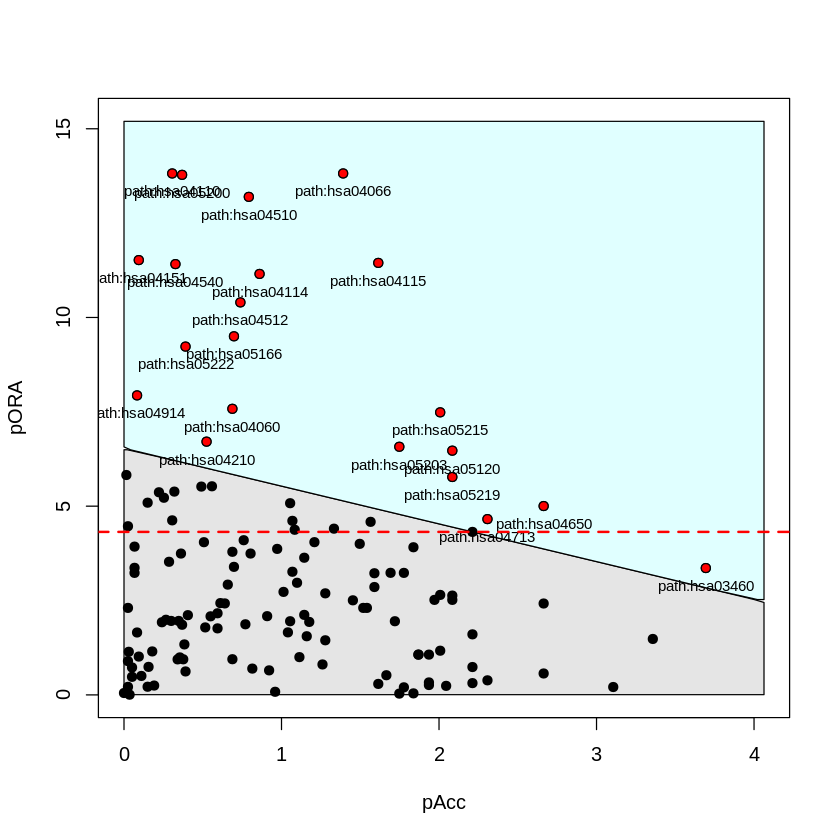

In [302]:
plot(peRes)

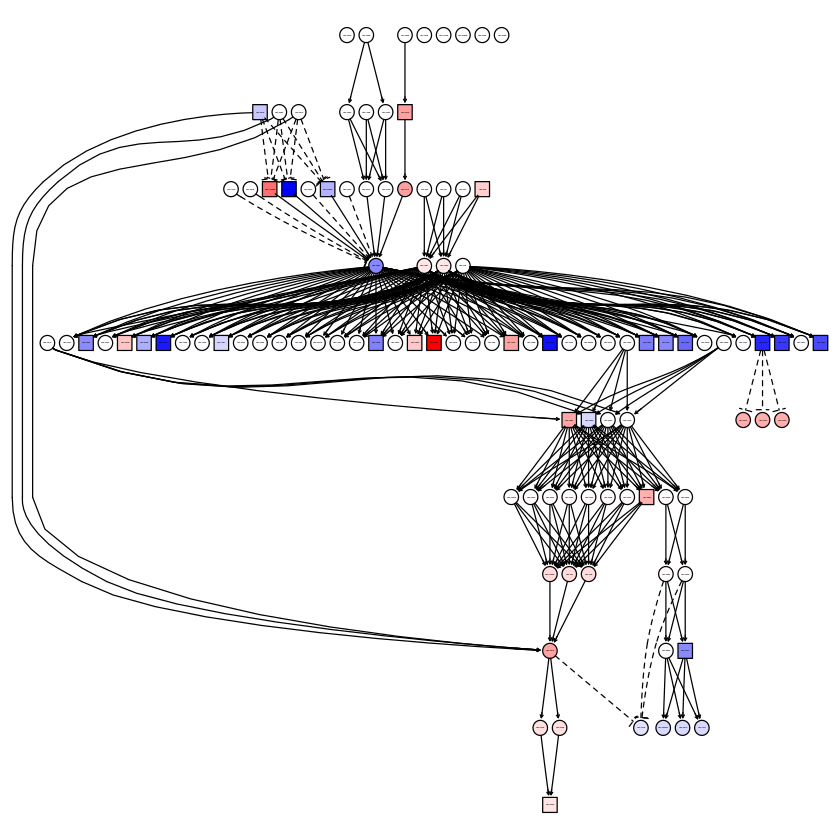

In [380]:
#Other visualization methods available in ROntoTools documentation
#Pathway pertubation
p <- peRes@pathways[["path:hsa04066"]]
g <- layoutGraph(p@map, layoutType = "dot")
graphRenderInfo(g) <- list(fixedsize = FALSE)
edgeRenderInfo(g) <- peEdgeRenderInfo(p)
nodeRenderInfo(g) <- peNodeRenderInfo(p)
renderGraph(g)

## QuaternaryProd with STRING database
From https://bioconductor.org/packages/release/bioc/vignettes/QuaternaryProd/inst/doc/QuaternaryProdVignette.pdf

Data set needs:
1. entrez ID of gene
2. pvalue of gene
3. fold change of gene

In [357]:
#renamecolumns to match package expectations (log2FoldChange -> fc)
top_H358_72_MB$fc <- top_H358_72_MB$log2FoldChange
#isolate entrez, pvalue, and fc columns
quat_H358_72_MB <- data.frame(top_H358_72_MB$entrez, top_H358_72_MB$pvalue, top_H358_72_MB$fc)
names(quat_H358_72_MB) <- c("entrez", "pvalue", "fc")
#make entrez column character instead of factor
quat_H358_72_MB$entrez <- as.character(quat_H358_72_MB$entrez)
#remove duplicated entrez ids
quat_H358_72_MB <- quat_H358_72_MB[!duplicated(quat_H358_72_MB$entrez),]

In [347]:
library(QuaternaryProd)

Loading required package: Rcpp

Loading required package: yaml



In [358]:
# Compute the Quaternary Dot Product Scoring Statistic for only statistically
# significant regulators
#see package/papers for stats info
#takes ~40 min to complete
quaternary_results <- RunCRE_HSAStringDB(quat_H358_72_MB, method = "Quaternary",
                                   fc.thresh = log2(1.3), pval.thresh = 0.05,
                                   only.significant.pvalues = TRUE,
                                   significance.level = 0.05,
                                   epsilon = 1e-16, progressBar = FALSE,
                                   relations = NULL, entities = NULL)


(1/5) Begin Processing...
(2/5) 610 rows from gene_expression_data removed due 
 		 to entrez ids being unrepsented in network entities!
(3/5) Loading STRINGdb causal network...
(4/5) Computing P-values...
(5/5) Done.


In [359]:
#view first four rows of results
#pvalue = -1 => p>0.05, not exactly calculated to improve performance
quaternary_results[1:4, c("uid","symbol","regulation","pvalue")]

,uid,symbol,regulation,pvalue
,<chr>,<chr>,<chr>,<dbl>
1,9606.ENSP00000342307,FOXM1,down,1.738489e-09
2,9606.ENSP00000463999,AURKB,down,2.582227e-09
3,9606.ENSP00000351407,ARNT,down,3.510620e-08
4,9606.ENSP00000345571,E2F1,down,4.181856e-08


In [378]:
#export results
write.csv(quaternary_results, "Results/QuaternaryProd/H358_72h_MvsMB_QuatProd.csv")

## GSEA with GAGE/Pathview and KEGG pathways
From http://bioconductor.org/packages/release/bioc/vignettes/gage/inst/doc/RNA-seqWorkflow.pdf

In [143]:
library(gage)
ref.idx=5:8
samp.idx=1:4
data(kegg.gs)

In [326]:
#see all kegg pathways in database loaded
#kegg.gs